## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. You can add more notebook cells to test out or debug your code. We actually highly recommend you do so to gain a better understanding of what is happening. However, **during grading, these cells are ignored**.
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.

# Supervised Learning - SVM and Kernel Method

In this exercise we'll go over an example of how to efficiently run a k-fold cross validation experiment and apply that to some variations of SVM with different kernels.

First, let's go over [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). GridSearchCV allows you to pass in a set of parameters that you want to try out and it will search those for you. GridSearch also takes a scorer method that allows it to compare the models it has trained. After finding the best hyperparameter it'll train the model again on the whole training data.

Here's what it does again in a step by step format:

1. Train all the models it can create based on the specified parameters and a k-fold 
1. Score each model
1. Determine the best hyperparameter for the models based on the selected scoring method
1. Trains the model on the entire training set using the best hyperparameters

You can still use the fit() and predict() methods you're used to with other methods on the GridSearchCV object.

Scikit-learn also already has an [SVM classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) that we can use. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk

%matplotlib inline
plt.style.use("ggplot")

In [2]:
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC # This is the SVM classifier

In [3]:
X, y = make_blobs(n_samples=1000,random_state=0)

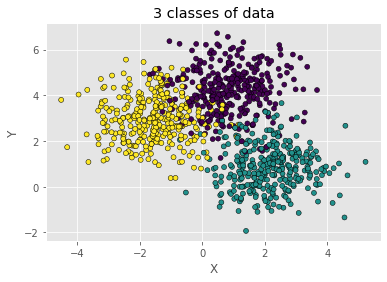

In [4]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.title("3 classes of data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

print(f"All Data:        {len(X)} points")
print(f"Training data:   {len(X_train)} points")
print(f"Testing data:    {len(X_test)} points")

All Data:        1000 points
Training data:   800 points
Testing data:    200 points


First, let's decide on the parameters and scoring method we want to try out for SVM. We'll set the parameters as varying values for C and we won't really test out the other values. The grid search will use default values for all the other parameters.

We'll pick a random state and gamma value that is just one value so it'll be the same for all models. Random state is the seed for the random number generator. Having exactly one ensures reproducable results and mnimizes effects due to randomness. Gamma is a kernel coefficient that we can customize. For simplicity, we'll set it to "auto". You can read more about these parameters in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).


In [6]:
params = {
    "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
    "random_state": [0],
    "gamma": ["auto"]
}


For the scoring parameter, we can select one of many options from [this list](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter). Let's go with `"accuracy"`. Also, set an integer value for `cv` of your choosing - this is the $k$ to use for a stratified $k$-fold cross validation.

In [7]:
# Create a GridSearchCV with the provided parameters and use the accuracy scoring method.
# Set the classifier you create to the `clf` variable
clf = GridSearchCV(SVC(), params, scoring = 'accuracy', cv = 10)

In [8]:
assert clf.get_params()["param_grid"] == params
assert clf.get_params()["scoring"] == "accuracy"

Now that we have the classifier, let's fit it to the data and determine the best score we get.

In [9]:
# Fit the clf estimator to the data
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 100.0,
                               1000.0, 10000.0],
                         'gamma': ['auto'], 'random_state': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

You can extract the best estimator, best score and best parameters from the GridSearchCV object as shown in the next few cells:

In [10]:
clf.best_estimator_

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [11]:
clf.best_score_

0.9200000000000002

In [12]:
clf.best_params_

{'C': 0.1, 'gamma': 'auto', 'random_state': 0}

In [13]:
assert clf.best_score_ > 0.85

Now let's see how well the model does on the test data. There are multiple ways you can do this. 

We previously would predict using the `.predict()` method and then use our scoring method such as `f1_score` to determine the score. Since we already told the estimator the scoring method we want to use, we can just use `clf.score()`. Try it out and save the result to `testScore`.

Remember, you can hit the tab key to see the documentation on the function you're using.

In [14]:
# Use clf.score and store the values to testScore
testScore = clf.score(X_test, y_test)

In [15]:
assert testScore > 0.85
assert testScore != clf.best_score_

This is great, you've just learned how to use GridSearchCV. Now let's look at the different kernels we can use with SVMs and the effect they have on data.

Now we'll look at the polynomial kernel and when it works well.

In [16]:
circlesX, circlesY = make_circles(300, noise=0.1, random_state=0, factor=0.1)

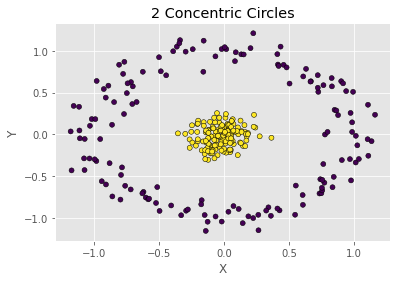

In [17]:
plt.scatter(circlesX[:, 0], circlesX[:, 1], marker='o', c=circlesY, s=25, edgecolor='k')
plt.title("2 Concentric Circles")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Now let's try GridSearch again with multiple kernels and multiple values.

In [18]:
circleParams = {
    "kernel": ["linear", "poly"],
    "degree": [1, 2, 3],
    "C": [1e-2, 1e-1, 1, 1e2],
    "random_state": [0],
    "gamma": ["auto"]
}

In [19]:
circles_X_train, circles_X_test, circles_y_train, circles_y_test = train_test_split(circlesX, circlesY, random_state=0, test_size=0.2)

print(f"All Data:        {len(circlesX)} points")
print(f"Training data:   {len(circles_X_train)} points")
print(f"Testing data:    {len(circles_X_test)} points")

All Data:        300 points
Training data:   240 points
Testing data:    60 points


Repeat everything we did before with GridSearch but now run it all in one cell. Save the classifier as `circlesClf` and the score as `circlesScore`.

Use `"f1_weighted"` as the scoring method.

In [20]:
# Create a circlesClf gridsearchCV classifier that uses the circleParams and accuracy score
# Score the classifier on the test data and save the score as circlesScore
# This will take a while to run!

circlesClf = GridSearchCV(SVC(), circleParams, scoring = 'f1_weighted', cv = 5)
circlesClf.fit(circles_X_train, circles_y_train)
circlesScore = circlesClf.score(circles_X_test, circles_y_test)

In [21]:
circlesClf.best_estimator_

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [22]:
circlesScore

1.0

In [23]:
circlesClf.best_score_

1.0

In [24]:
assert circlesScore > 0.85

The next section is some example code copied from the sklearn documentation that shows the different decision boundaries based on the kernel you choose to use. This should help you gain some intuition around why some kernels may be better than others.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


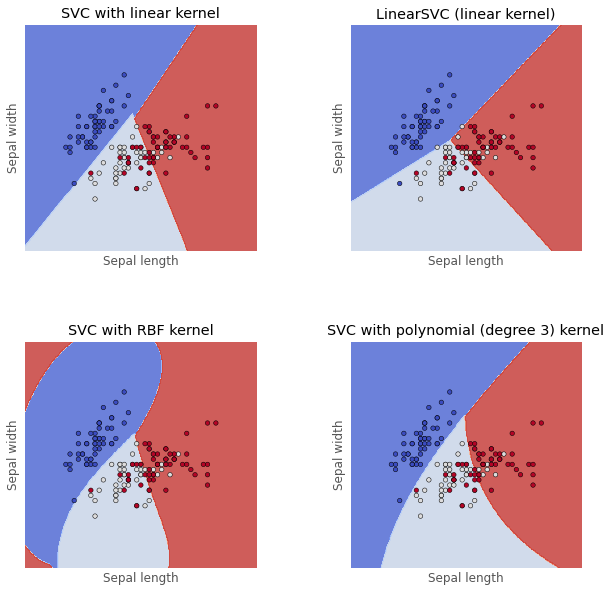

In [25]:
## CODE FROM https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
iris = sk.datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (sk.svm.SVC(kernel='linear', C=C),
          sk.svm.LinearSVC(C=C),
          sk.svm.SVC(kernel='rbf', gamma=0.7, C=C),
          sk.svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

## Feedback

In [26]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    return "All good!"

In [27]:
print(feedback())

All good!
